In [1]:
import polars as pl
import pandas as pd

pl.Config.set_fmt_str_lengths(200)
pl.Config.set_fmt_float("full")

polars.config.Config

In [2]:
df_filepaths = 'data/univ3/*.parquet'

In [3]:
df_filepaths = 'data/univ3/*.parquet'

In [4]:
def get_largest_tokenIn_vol(df_filepaths: str, blockchain: str) -> pl.DataFrame:
    q = (
        pl.scan_parquet(df_filepaths)
        .filter((pl.col("blockchain") == blockchain) & (pl.col('timestamp') >= pl.date(2023, 4, 1)))
        .groupby('tokenIn_symbol')
        .agg(pl.col("amountInUSD").sum())
        .sort(by="amountInUSD", descending=True)
    )
    df = q.collect()

    # add blockchain column
    df = df.with_columns(pl.lit(blockchain).alias('blockchain'))

    # rename column
    df = df.select(
        pl.col('tokenIn_symbol').alias('token'),
        pl.col('amountInUSD').alias('volume'),
        pl.col('blockchain')
    )

    return df

def get_largest_tokenOut_vol(df_filepaths: str, blockchain: str) -> pl.DataFrame:
    q = (
        pl.scan_parquet(df_filepaths)
        .filter((pl.col("blockchain") == blockchain) & (pl.col('timestamp') >= pl.date(2023, 4, 1)))
        .groupby('tokenOut_symbol')
        .agg(pl.col("amountOutUSD").sum())
        .sort(by="amountOutUSD", descending=True)
    )
    df = q.collect()

    # add blockchain column
    df = df.with_columns(pl.lit(blockchain).alias('blockchain'))

    # rename column
    df = df.select(
        pl.col('tokenOut_symbol').alias('token'),
        pl.col('amountOutUSD').alias('volume'),
        pl.col('blockchain')
    )

    return df

def get_all_token_vol(df_filepaths: str, blockchain: str) -> pl.DataFrame:
    df_in = get_largest_tokenIn_vol(df_filepaths, blockchain)
    df_out = get_largest_tokenOut_vol(df_filepaths, blockchain)

    # concat
    df = pl.concat([df_in, df_out])

    # groupby token and sum volume again
    df = df.groupby('token').agg(pl.col('volume').sum()).sort(by='volume', descending=True)

    # add blockchain column
    df = df.with_columns(pl.lit(blockchain).alias('blockchain'))
    
    return df

In [5]:
eth_data = get_all_token_vol(df_filepaths, 'ethereum')
arb_data = get_all_token_vol(df_filepaths, 'arbitrum')
opt_data = get_all_token_vol(df_filepaths, 'optimism')
poly_data = get_all_token_vol(df_filepaths, 'polygon')
bsc_data = get_all_token_vol(df_filepaths, 'bsc')

PARTITIONED DS
PARTITIONED DS
PARTITIONED DS
PARTITIONED DS
PARTITIONED DS
PARTITIONED DS
PARTITIONED DS
PARTITIONED DS
PARTITIONED DS
PARTITIONED DS


In [6]:
# bsc doesn't have 'weth', they have binance pegged eth with symbol ETH.
bsc_data = bsc_data.with_columns(
    pl.when(pl.col('token') == 'ETH').then(pl.lit('WETH')).otherwise(pl.col('token')).alias('token')
)

# do the same with BTCB and WBTC
bsc_data = bsc_data.with_columns(
    pl.when(pl.col('token') == 'BTCB').then(pl.lit('WBTC')).otherwise(pl.col('token')).alias('token')
)

In [7]:
# concat data
token_vol_df = pl.concat([eth_data, arb_data, opt_data, poly_data, bsc_data])

# sort
token_vol_df = token_vol_df.sort(by="volume", descending=True)

### Plotting

In [8]:
token_vol_df_pandas = token_vol_df.head(30).to_pandas()

In [9]:
token_vol_df_pandas.head(5)

,token,volume,blockchain
0,WETH,6.369028e+10,ethereum
1,USDC,5.589333e+10,ethereum
2,WETH,2.420472e+10,arbitrum
3,USDT,2.345942e+10,ethereum
4,USDC,1.615208e+10,arbitrum


In [10]:
# pivot blockchain column to column headers. Make token the index
pivot_df = token_vol_df_pandas.pivot(index='token', columns='blockchain', values='volume')

In [11]:
# create a new sum column
pivot_df['sum'] = pivot_df.sum(axis=1)

In [12]:
pivot_df = pivot_df.sort_values(by='sum', ascending=True)

In [13]:
pivot_df

blockchain,arbitrum,bsc,ethereum,optimism,polygon,sum
token,,,,,,
BLUR,NaN,NaN,4.550795e+08,NaN,NaN,4.550795e+08
LDO,NaN,NaN,5.810254e+08,NaN,NaN,5.810254e+08
OP,NaN,NaN,NaN,6.226160e+08,NaN,6.226160e+08
cbETH,NaN,NaN,6.731571e+08,NaN,NaN,6.731571e+08
GMX,6.911443e+08,NaN,NaN,NaN,NaN,6.911443e+08
HEX,NaN,NaN,1.107060e+09,NaN,NaN,1.107060e+09
BUSD,NaN,1.791735e+09,NaN,NaN,NaN,1.791735e+09
PEPE,NaN,NaN,1.987861e+09,NaN,NaN,1.987861e+09
WMATIC,NaN,NaN,NaN,NaN,2.721458e+09,2.721458e+09


In [14]:
# get top 5 largest sum value rows
pivot_df = pivot_df.tail(5)

# fill NaN values with 0
pivot_df = pivot_df.fillna(0)

In [15]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import thanefield_charting as tc

# Format the y-axis tick labels
def format_y_ticks(value, pos):
    if value >= 1e9:
        return f'${value / 1e9:.1f}B'
    elif value >= 1e6:
        return f'${value / 1e6:.1f}M'
    elif value >= 1e3:
        return f'${value / 1e3:.1f}K'
    else:
        return f'${value:.0f}'


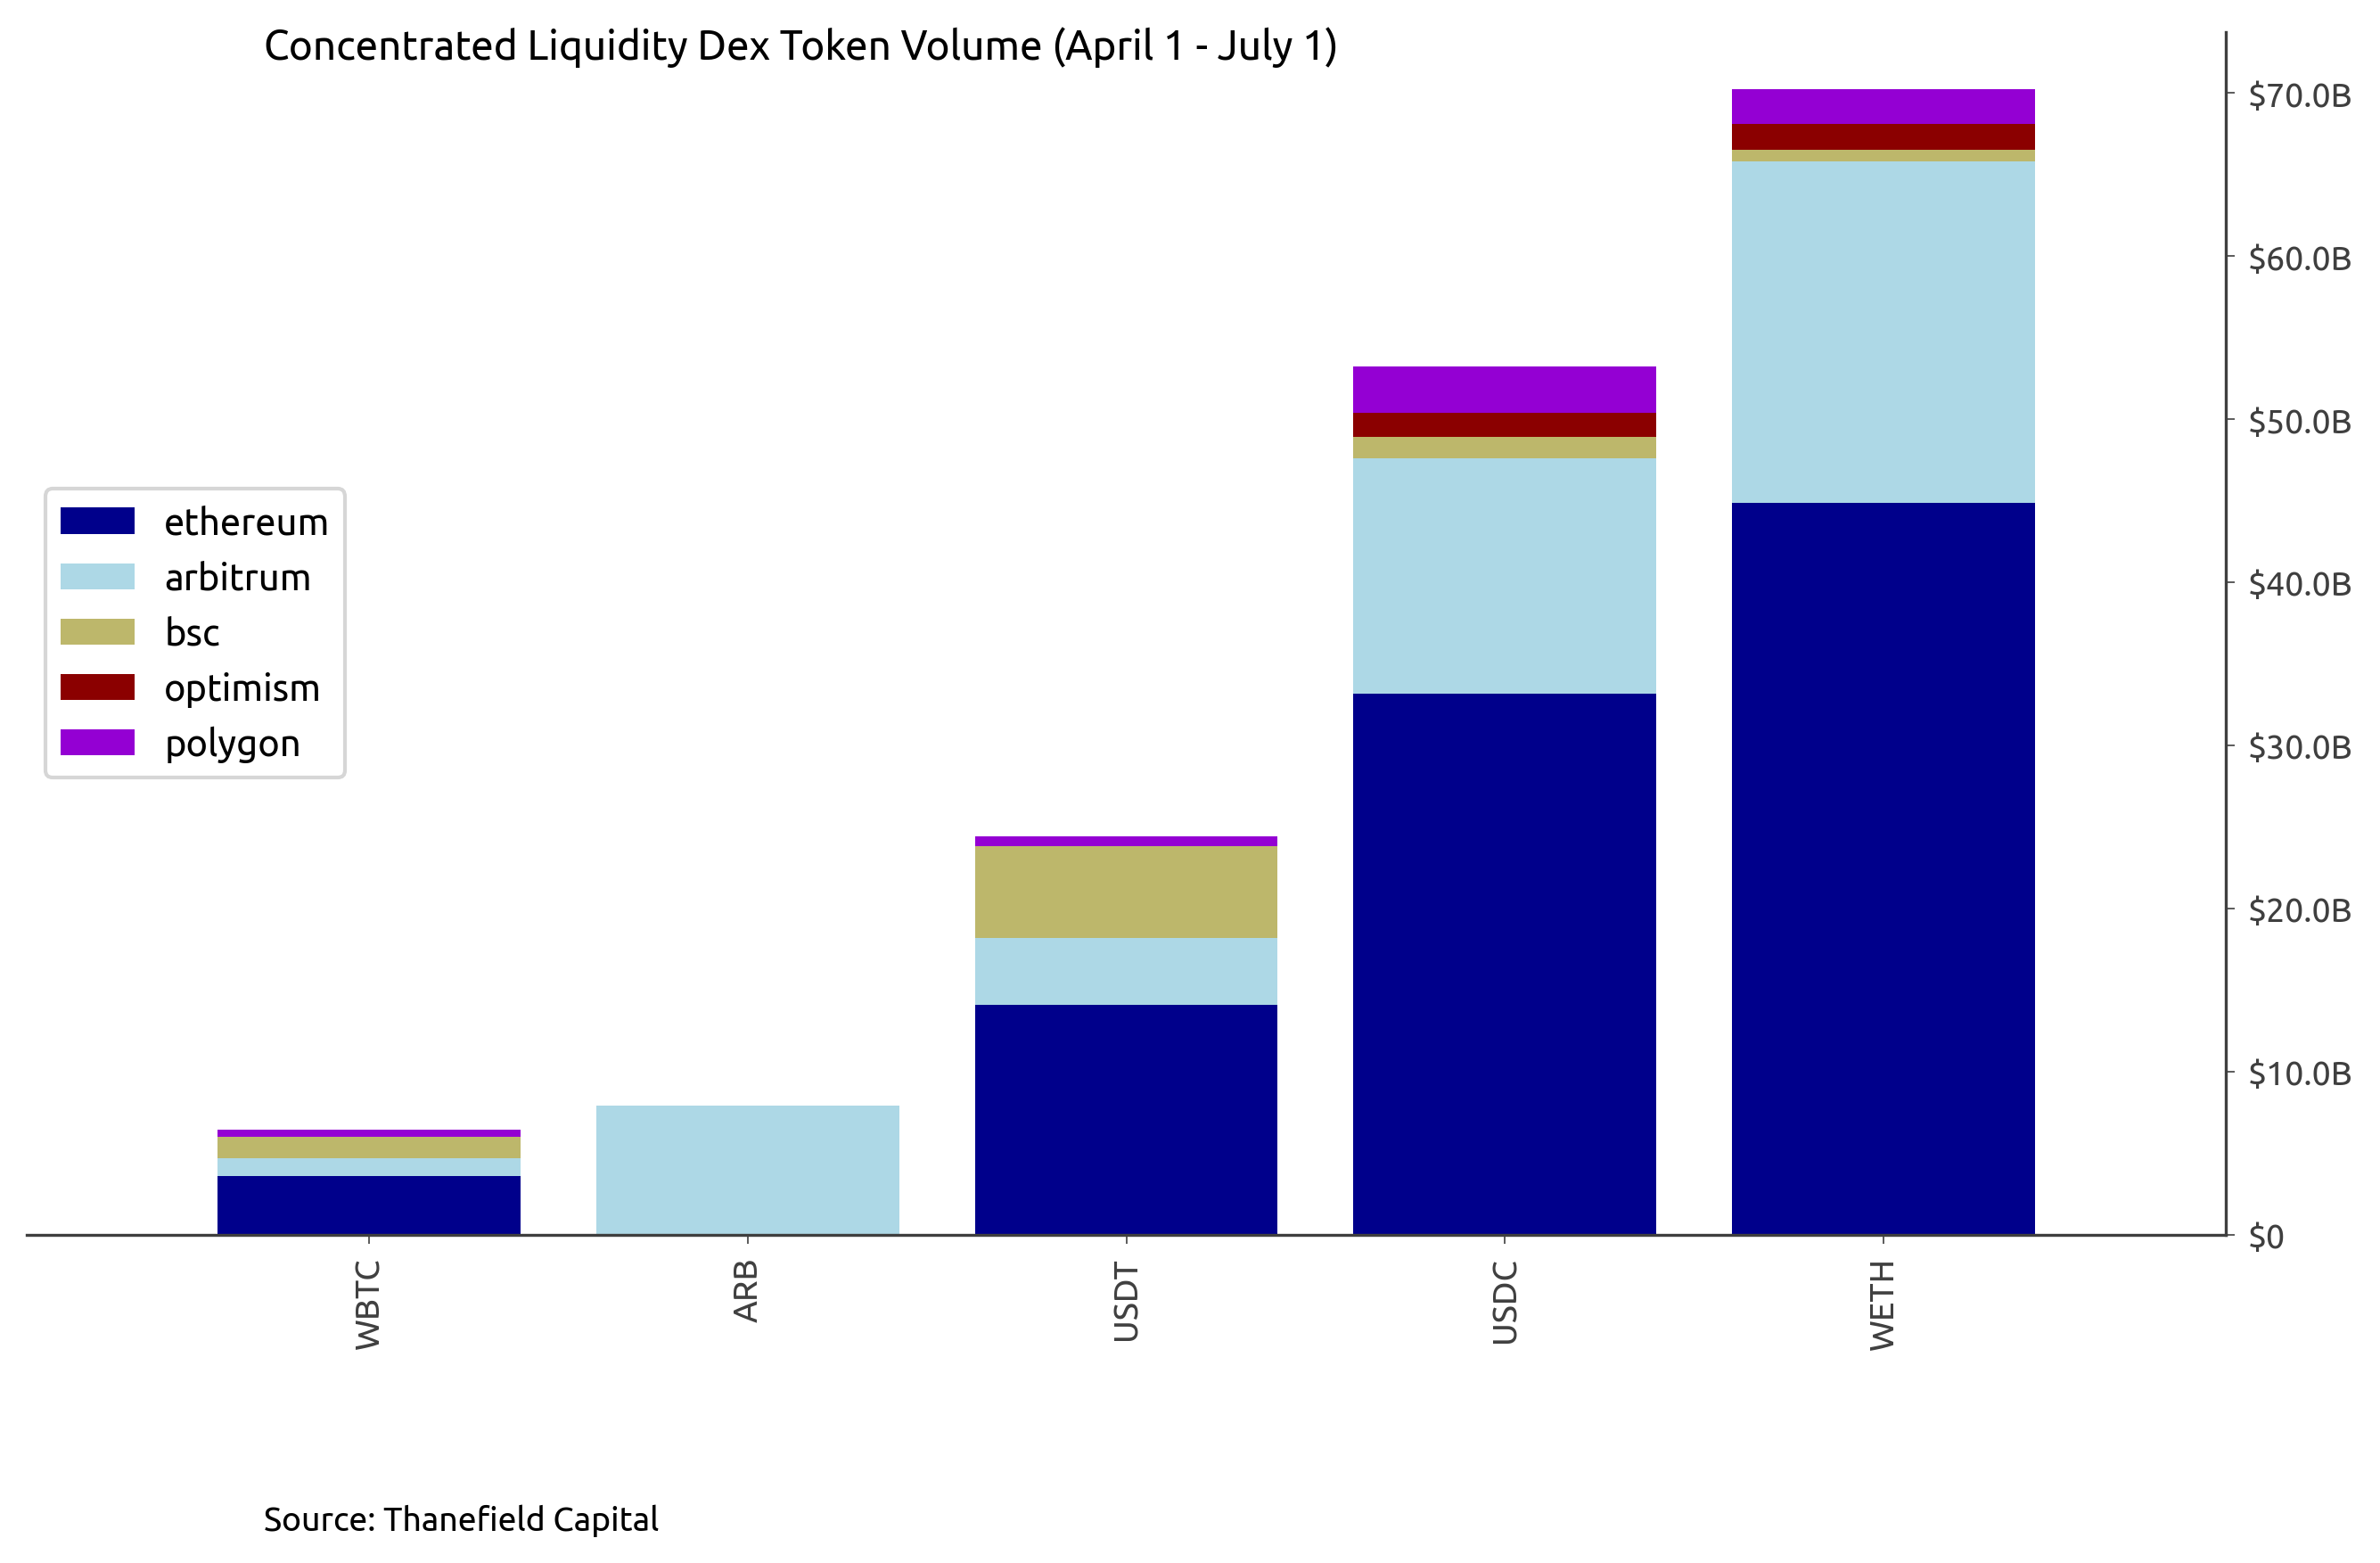

In [ ]:
# note each token has over 1b volume
fig, ax = tc.chart('Concentrated Liquidity Dex Token Volume (April 1 - July 1)', dates=False)

ax.bar(pivot_df.index, pivot_df['ethereum'], color='darkblue', label='ethereum')
ax.bar(pivot_df.index, pivot_df['arbitrum'], color='lightblue', label='arbitrum', bottom=pivot_df['ethereum'])
ax.bar(pivot_df.index, pivot_df['bsc'], color='darkkhaki', label='bsc', bottom=pivot_df['ethereum']+pivot_df['arbitrum'])
ax.bar(pivot_df.index, pivot_df['optimism'], color='darkred', label='optimism', bottom=pivot_df['ethereum']+pivot_df['arbitrum']+pivot_df['bsc'])
ax.bar(pivot_df.index, pivot_df['polygon'], color='darkviolet', label='polygon', bottom=pivot_df['ethereum']+pivot_df['arbitrum']+pivot_df['bsc']+pivot_df['optimism'])


# Apply the custom formatting function to the y-axis
ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_y_ticks))

# formatting
# tc.legend(ax)
tc.set_xmargin(ax, margin=.05)
plt.tight_layout()
plt.xticks(rotation=90)
plt.legend(loc='center left')

# save chart
# tc.save('charts/dex_total_token_vol.png')